In [1]:
import os, os.path
import pickle
import numpy
from scipy import special
numpy.random.seed(1)
from scipy import optimize
import corner
import bovy_mcmc
from galpy.util import bovy_plot, save_pickles
import MWPotential2014Likelihood
from matplotlib.ticker import NullFormatter
from matplotlib import gridspec, cm
%pylab inline
_REFR0, _REFV0= 8.2, 224.
save_figures= True
# Read the necessary data
#First read the surface densities
surffile= '../mwpot14data/bovyrix13kzdata.csv'
if not surffile is None and os.path.exists(surffile):
    surf= numpy.loadtxt(surffile,delimiter=',')
    surfrs= surf[:,2]
    kzs= surf[:,6]
    kzerrs= surf[:,7]
# Then the terminal velocities
cl_glon, cl_vterm, cl_corr= MWPotential2014Likelihood.readClemens(dsinl=0.125)
mc_glon, mc_vterm, mc_corr= MWPotential2014Likelihood.readMcClureGriffiths(dsinl=0.125)
termdata= (cl_glon,cl_vterm/_REFV0,cl_corr,
           mc_glon,mc_vterm/_REFV0,mc_corr)

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib
/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)



# MWPotential2014 constraints with variable halo flattening

In [2]:
def fit(fitc=False,c=1.,R0=_REFR0,V0=_REFV0,dblexp=False,plots=True):
    init_params= [0.5,0.45,numpy.log(2.5/R0),numpy.log(0.4/R0),
                  numpy.log(20./R0),0.,0.]
    if fitc:
        init_params.append(1.)
    funcargs= (c,surfrs,kzs,kzerrs,termdata,7.,fitc,dblexp,R0,V0)
    params= optimize.fmin_powell(MWPotential2014Likelihood.like_func,
                                 init_params,args=funcargs,disp=False)
    if plots:
        pot= MWPotential2014Likelihood.setup_potential(params,*funcargs)
        subplot(1,3,1)
        MWPotential2014Likelihood.plotRotcurve(pot)
        subplot(1,3,2)
        MWPotential2014Likelihood.plotKz(pot,surfrs,kzs,kzerrs,R0,V0)
        subplot(1,3,3)
        MWPotential2014Likelihood.plotTerm(pot,termdata,R0,V0)
        tight_layout()
    return (params,MWPotential2014Likelihood.like_func(params,*funcargs))

In [3]:
def sample(nsamples=1000,params=None,fitc=False,c=1.,R0=_REFR0,V0=_REFV0,dblexp=False,plots=True):
    if params is None:
        params= fit(fitc=fitc,c=c,R0=R0,V0=V0,dblexp=dblexp,plots=False)[0]
    funcargs= (c,surfrs,kzs,kzerrs,termdata,7.,fitc,dblexp,R0,V0)
    samples=\
        bovy_mcmc.markovpy(params,0.2,
                           lambda x: -MWPotential2014Likelihood.like_func(x,*funcargs),(),
                           isDomainFinite=[[False,False] for ii in range(len(params))],
                           domain= [[0.,0.] for ii in range(len(params))],
                           nsamples=nsamples,
                           nwalkers=2*len(params))
    samples= numpy.array(samples).T
    if plots: plot_samples(samples,fitc,R0)
    return samples
def plot_samples(samples,fitc,R0):
    labels= [r'$f_d$',r'$f_h$',r'$a / \mathrm{kpc}$',r'$b / \mathrm{pc}$',
             r'$r_s / \mathrm{kpc}$']
    if fitc: labels.append(r'$c$')
    subset= numpy.ones(len(samples),dtype='bool')
    subset[5:7]= False
    plotsamples= samples[subset]
    plotsamples[2]= numpy.exp(samples[2])*R0
    plotsamples[3]= numpy.exp(samples[3])*1000.*R0
    plotsamples[4]= numpy.exp(samples[4])*R0
    corner.corner(plotsamples.T,quantiles=[0.16, 0.5, 0.84],labels=labels,
                  show_titles=True, title_args={"fontsize": 12})

## Basic, Bovy (2015) fit with $c=1$

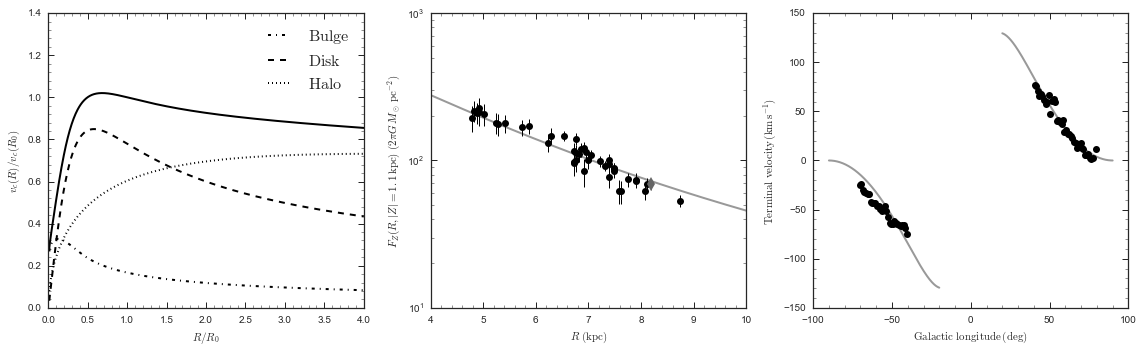

In [4]:
figsize(16,5)
p_b15= fit(fitc=False,c=1.)

## Fits with $c\neq1$

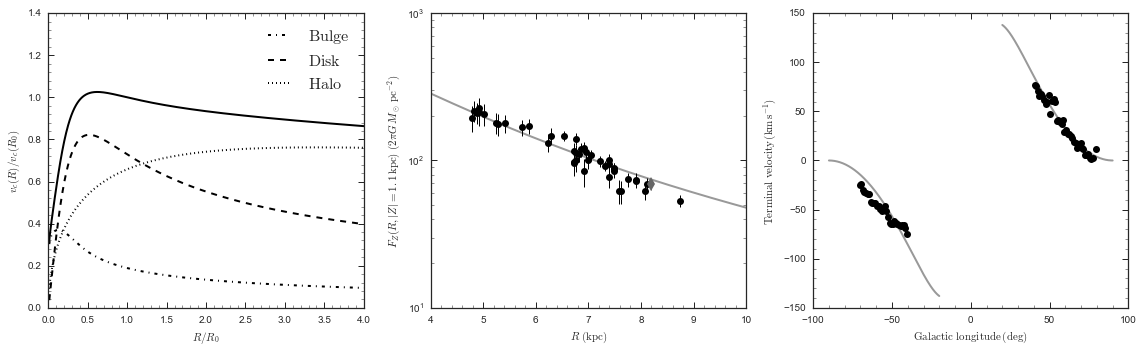

In [5]:
figsize(16,5)
p_b15_cp5= fit(fitc=False,c=0.5)

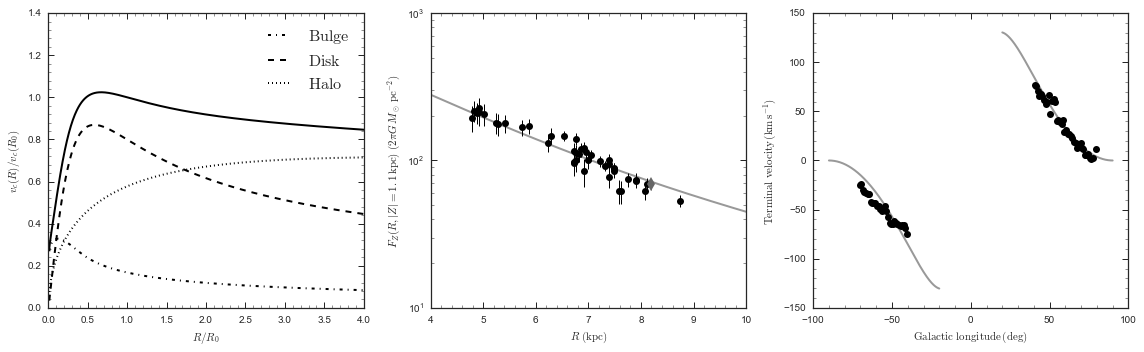

In [6]:
figsize(16,5)
p_b15_c1p5= fit(fitc=False,c=1.5)

All look pretty similar...

In [7]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,4.1,0.1)
    bf_params= []
    for c in cs:
        dum= fit(fitc=False,c=c)
        bf_params.append(dum[0])
    save_pickles('mwpot14varyc-bf.pkl',cs,bf_params)

##Fits with free $c$

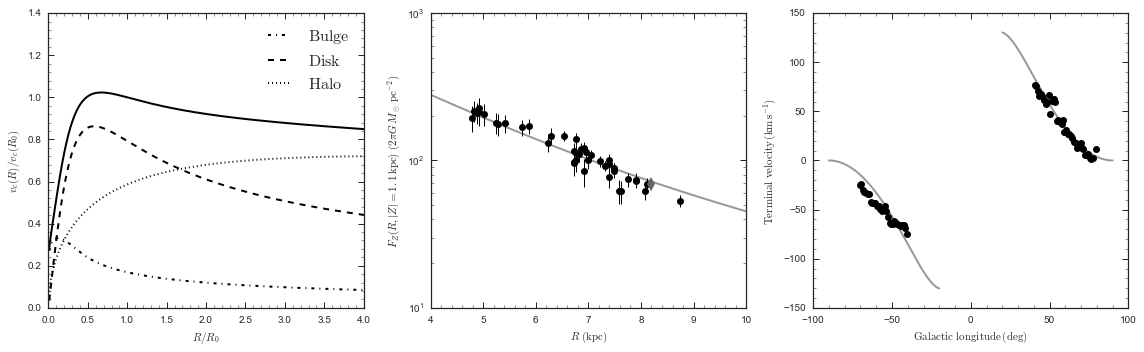

In [8]:
figsize(16,5)
p_b15_cfree= fit(fitc=True,c=None)

In [9]:
samples_savefilename= 'mwpot14varyc-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    s= sample(nsamples=100000,params=p_b15_cfree[0],fitc=True,c=None,R0=_REFR0,V0=_REFV0,plots=False)
    save_pickles('mwpot14varyc-samples.pkl',s)

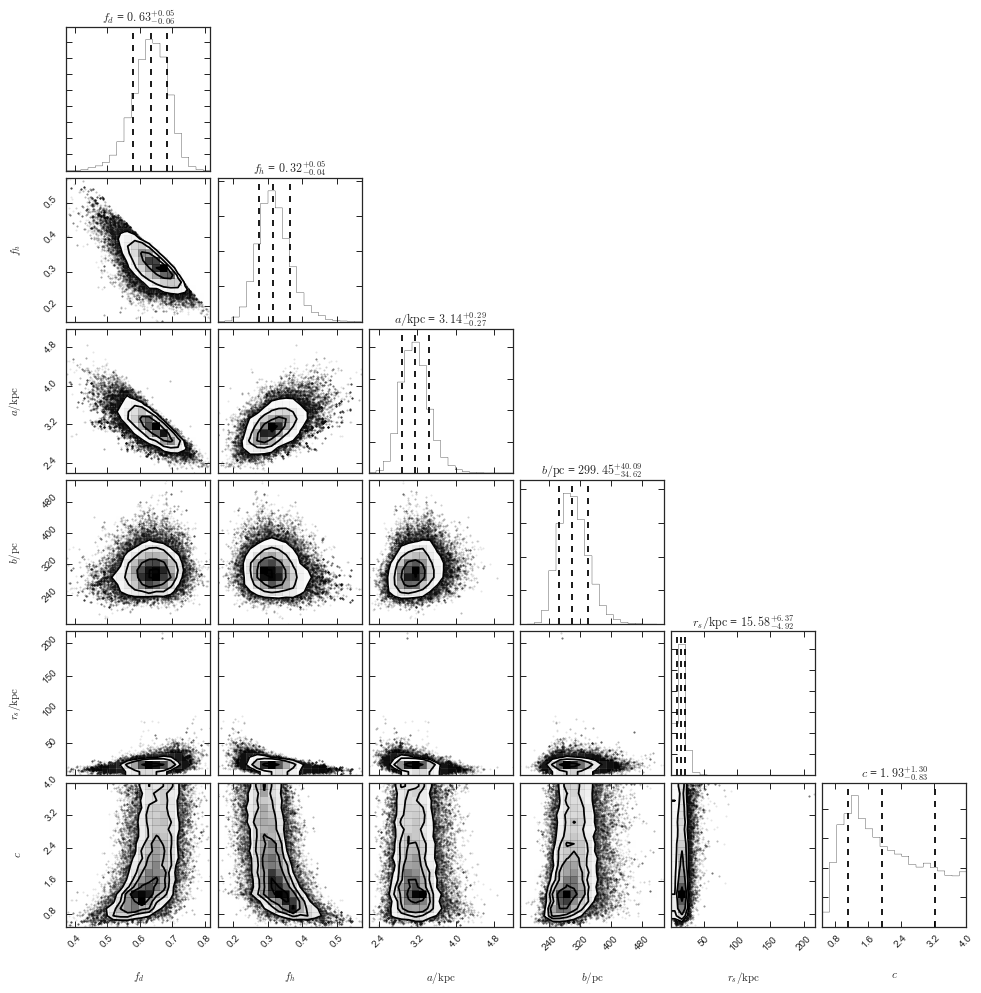

In [10]:
plot_samples(s,True,_REFR0)

Nice plot of the $c$ dependence of the other quantities

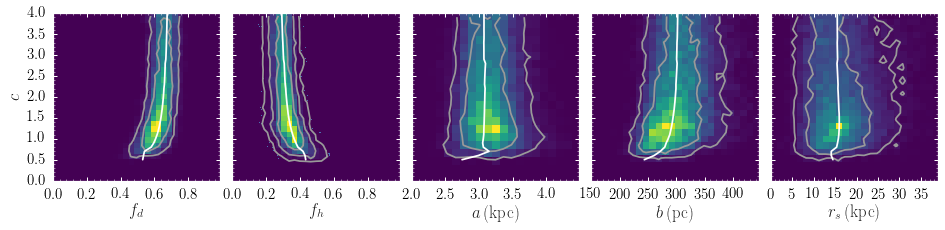

In [11]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
cmap= cm.viridis
levels= list(special.erf(numpy.arange(1,3)/numpy.sqrt(2.)))
levels.append(1.01)
def axes_white():
    for k, spine in gca().spines.items():  #ax.spines is a dictionary
        spine.set_color('w')
    gca().tick_params(axis='x',which='both',colors='w')
    gca().tick_params(axis='y',which='both',colors='w')
    [t.set_color('k') for t in gca().xaxis.get_ticklabels()]
    [t.set_color('k') for t in gca().yaxis.get_ticklabels()]
    return None
figsize(16,3)
gs=  gridspec.GridSpec(1,5,wspace=0.025)
subplot(gs[0])
bovy_plot.scatterplot(s[0],s[7],',',gcf=True,bins=31,cmap=cmap,cntrcolors='0.6',
                     xrange=[0.,.99],yrange=[0.,4.],levels=levels,
                     xlabel=r'$f_d$',ylabel=r'$c$',zorder=1)
bovy_plot.bovy_plot([bp[0] for bp in bf_params],cs,'w-',overplot=True)
axes_white()
subplot(gs[1])
bovy_plot.scatterplot(s[1],s[7],',',gcf=True,bins=31,cmap=cmap,cntrcolors='0.6',
                     xrange=[0.,.99],yrange=[0.,4.],
                     xlabel=r'$f_h$')
bovy_plot.bovy_plot([bp[1] for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
subplot(gs[2])
bovy_plot.scatterplot(numpy.exp(s[2])*_REFR0,s[7],',',gcf=True,bins=21,levels=levels,
                     xrange=[2.,4.49],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                     xlabel=r'$a\,(\mathrm{kpc})$')
bovy_plot.bovy_plot([numpy.exp(bp[2])*_REFR0 for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
subplot(gs[3])
bovy_plot.scatterplot(numpy.exp(s[3])*_REFR0*1000.,s[7],',',gcf=True,bins=26,levels=levels,
                     xrange=[150.,445.],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                     xlabel=r'$b\,(\mathrm{pc})$')
bovy_plot.bovy_plot([numpy.exp(bp[3])*_REFR0*1000. for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
subplot(gs[4])
bovy_plot.scatterplot(numpy.exp(s[4])*_REFR0,s[7],',',gcf=True,bins=26,levels=levels,
                     xrange=[0.,39.],yrange=[0.,4.],cmap=cmap,cntrcolors='0.6',
                     xlabel=r'$r_s\,(\mathrm{kpc})$')
bovy_plot.bovy_plot([numpy.exp(bp[4])*_REFR0 for bp in bf_params],cs,'w-',overplot=True)
nullfmt= NullFormatter()
gca().yaxis.set_major_formatter(nullfmt)
axes_white()
if save_figures:
    plt.savefig('mwpot14-varyc.pdf',bbox_inches='tight')

2.5% and 0.5% lower limits: 0.74, 0.62


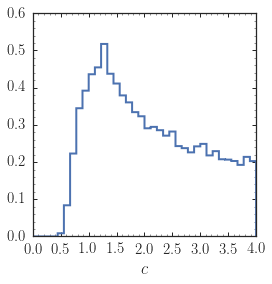

In [12]:
figsize(4,4)
dum= bovy_plot.bovy_hist(s[7],bins=36,histtype='step',lw=2.,
                        xlabel=r'$c$',xrange=[0.,4.],normed=True)
sortedc= numpy.array(sorted(s[7]))
print "2.5%% and 0.5%% lower limits: %.2f, %.2f" % \
    (sortedc[int(numpy.floor(0.025*len(sortedc)))],
     sortedc[int(numpy.floor(0.005*len(sortedc)))])